# Poisson Image Editing - Approche de Fourier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

Ce notebook est constitué de 2 parties : 
- la partie 1 *le principe* explique la théorie derrière l'algorithme, il n'y a quasiment pas de code (mis à part pour montrer quelques résultats visuels)
- la partie 2 *le code* implémente ce qui a été vu dans la partie 1

## 1 - Le principe

Le but de ce projet est d'implémenter un algorithme de retouche d'image appelé **Poisson Image Editing**, et plus particulièrement une version de celui-ci utilisant la Transformée de Fourier Discrète (TFD, ou DFT en anglais).  
L'objectif de la retouche ici est de pouvoir incruster une image $u$ dans une autre image $I$, et ce de façon "naturelle".   

Les quatre images ci-dessous illustrent notre objectif :
- celle en haut à gauche est l'image $u$ que l'on souhaite incruster
- celle en haut à droite est l'image $I$ sur laquelle on veut incruster $u$
- celle en bas à gauche est le résultat obtenu par un simple copier-coller de $u$ dans $I$.
- celle en bas à droite est le résultat obtenu grâce à l'algorithme Poisson Image Editing.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


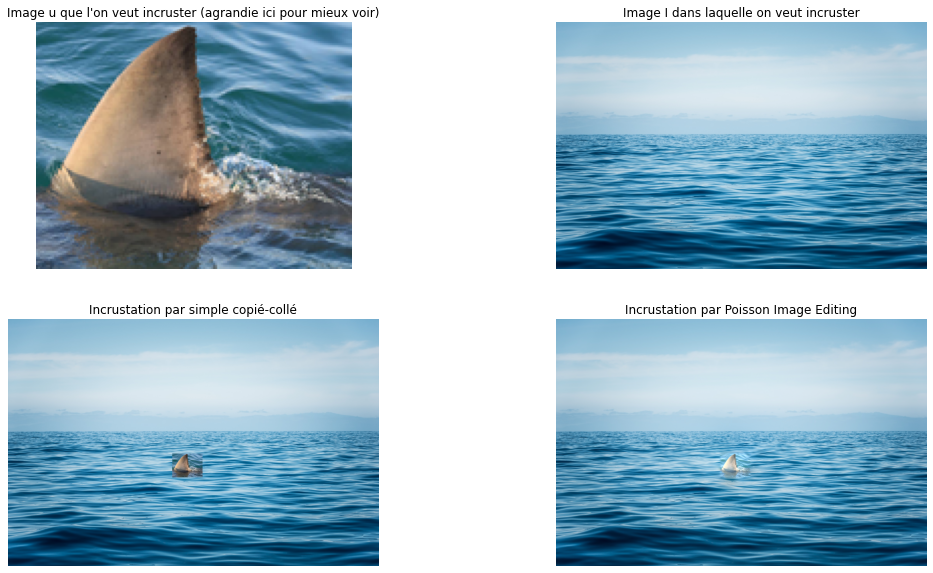

In [20]:
# <!> Cette cellule n'est là que pour afficher l'objectif, le code n'est pas important. <!>
# Le code utilisé ici est expliqué en détails dans la partie 2.

I = plt.imread('ocean.png')
u = plt.imread('requin.png')
Omega0x,Omega0y = 850,700

def copierColler(I,u,Omega0x,Omega0y):
    u=u[:,:,:3]
    J = np.copy(I)
    h,w = u.shape[0],u.shape[1]
    J[Omega0y:Omega0y+h,Omega0x:Omega0x+w] = u
    return J

C = copierColler(I,u,Omega0x,Omega0y)
J = BalancerCouleur(lancementCouleur(I, u, [Omega0x,Omega0y],0),I)

fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.imshow(u)
ax1.set_title("Image u que l'on veut incruster (agrandie ici pour mieux voir)")
ax1.axis('off')
ax2.imshow(I)
ax2.set_title("Image I dans laquelle on veut incruster")
ax2.axis('off')
ax3.imshow(C)
ax3.set_title("Incrustation par simple copié-collé")
ax3.axis('off')
ax4.imshow(J)
ax4.set_title("Incrustation par Poisson Image Editing")
ax4.axis('off')

plt.show()

Les données avec lesquelles nous allons travailler sont les suivantes :
- l'image $u$ que nous allons incruster
- l'image $I$ dans laquelle nous allons incruster.
- la zone $\Omega\subseteq I$ qui est l'endroit dans $I$ où nous allons incruster $u$. $\Omega$ est donc exactement de la même taille que $u$. Pour simplifier notre travail, nous considèrerons ici que $\Omega$ (et donc $u$) est rectangulaire. Pour préciser $\Omega$, il nous suffira donc simplement de préciser $(\Omega_{x};\Omega_{y})$ les coordonnées de son coin supérieur gauche.   

Les images $I$ et $u$ seront données sous la forme de matrices de pixels, où chaque pixel est la donnée d'un nombre pour les images en niveaux de gris, ou la donnée d'un triplet de nombres (RGB) pour les images en couleurs. Pour la suite des explications, nous considérerons uniquement les images en niveaux de gris, mais il suffit de séparer une image RGB en ses trois canaux de couleurs et d'appliquer séparément à chaque canal le raisonnement qui suit.  
Nous considérerons que $I$ est de taille $W_{I}\times H_{I}$, où $W_{I}$ sa longueur et $H_{I}$ est sa hauteur. Ainsi, nous pouvons voir $I$ comme une fonction qui à $(x,y)\in\{0,\ldots,W_{I}-1\}\times\{0,\ldots,H_{I}-1\}$ associe un nombre réel positif. Pour simplifier les notations, nous noterons $\mathcal{R}:=\{0,\ldots,W_{I}-1\}\times\{0,\ldots,H_{I}-1\}$, de sorte que $I:\mathcal{R}\to[0,+\infty[$.

Notons à présent $J$ le résultat final que nous souhaitons obtenir. $J$ est donc aussi une fonction $\mathcal{R}\to[0,+\infty[$. 

### a) L'équation à résoudre

L'idée à la base de l'algorithme de Poisson Image Editing est d'essayer de résoudre numériquement **l'équation de Poisson** suivante

$$(1)~~~~\forall (x,y)\in\Omega,\,\,\Delta J(x,y)=\mathrm{div}\Big(\nabla u(x,y)\Big)$$ 

avec la condition suivante, dite **condition de Dirichlet aux bords**, 

$$(2)~~~~\forall (x,y)\in\partial\Omega,J(x,y)=I(x,y)$$

Le but est donc de résoudre numériquement $(1)+(2)$. Il existe plusieurs méthodes pour approcher numériquement ce problème, et la version **approche de Fourier** consiste à modifier légèrement le système $(1)+(2)$ en l'équation :

$$(3)~~~~\forall (x;y)\in\mathcal{R},\,\,\Delta J(x,y)=\left\{\begin{array}{ll}\mathrm{div}\Big(\nabla u(x;y)\Big)&\mathrm{ si }\,\,(x;y)\in\Omega\\\mathrm{div}\Big(\nabla I(x;y)\Big)&\mathrm{ si }\,\,(x;y)\notin\Omega\end{array}\right.$$

avec la condition suivante, dite  **condition de Neumann aux bords** :
$$(4)~~~~\forall (x;y)\in\partial\mathcal{R},\,\,\nabla J(x;y)\cdot\overrightarrow{n}(x;y)=0$$
où $\partial\mathcal{R}$ est l'ensemble des coordonnées à la frontière de $\mathcal{R}$, et $\overrightarrow{n}(x;y)$ est le vecteur unitaire sortant de $\mathcal{R}$ à partir du point $(x;y)$.  
Par exemple, pour un pixel $(x;y)$ tout en bas de l'image, $\overrightarrow{n}(x;y)$ est un vecteur pointant vers le bas de l'image.  
Le but dans la suite sera donc d'essayer d'approcher numériquement une solution de $(3)+(4)$.

### b) Un peu de TFD

Pour comprendre la suite de l'algorithme, il faut faire un peu de Transformée de Fourier Discrète.  
Pour une fonction $f:\mathcal{R}\to\mathbb{R}$, sa TDF $\hat{f}$ est donnée par 

$$(\star_{1})~~~~\forall(a;b)\in\mathcal{R},\,\,\hat{f}(a;b)=\sum\limits_{x=0}^{W_{I}-1}\sum\limits_{y=0}^{H_{I}-1}f(x;y)e^{-2\pi i\big(\frac{xa}{W_{I}}+\frac{yb}{H_{I}}\big)}$$

Pour retrouver $f$ à partir de $\hat{f}$, il suffit alors d'appliquer la formule d'inversion suivante

$$(\star_{2})~~~~\forall(x;y)\in\mathcal{R},\,\,f(x;y)=\frac{1}{W_{I}H_{I}}\sum\limits_{a=0}^{W_{I}-1}\sum\limits_{b=0}^{H_{I}-1}\hat{f}(a;b)e^{2\pi i\big(\frac{xa}{W_{I}}+\frac{yb}{H_{I}}\big)}$$

En dérivant par rapport à $x$ et par rapport à $y$ l'égalité $(\star_{2})$, puis en appliquant à nouveau la TFD, on obtient les égalités suivantes 

$$(\star_{3})~~~~\forall(a,b)\in\mathcal{R},\,\,\widehat{\frac{\partial f}{\partial x}}(a,b)=\left(\frac{2\pi i}{W_{I}}a\right)\hat{f}(a,b)~~~~\text{ et }~~~~\widehat{\frac{\partial f}{\partial y}}(a,b)=\left(\frac{2\pi i}{H_{I}}b\right)\hat{f}(a,b)$$

Les égalités données par $(\star_{3})$ permettent alors de trouver de manière "simple" le gradient d'une image $f$ à partir de sa TFD $\widehat{f}$ puisqu'il suffit alors d'appliquer la TFD inverse au résultat obtenu. A chaque étape de l'algorithme où nous aurons besoin de calculer un gradient, nous pourrons ainsi ou bien utiliser la méthode classique **des différences finies**, ou bien utiliser $(\star_{3})$, que nous appellerons désormais **méthode du gradient par Fourier**.

### c) Retour à l'équation de Poisson

Pour tout $(x,y)\in\mathcal{R}$, en posant $V(x,y):=\left\{\begin{array}{ll}\nabla u(x;y)&\mathrm{ si }\,\,(x;y)\in\Omega\\\nabla I(x;y)&\mathrm{ si }\,\,(x;y)\notin\Omega\end{array}\right.$, l'équation $(3)$ se réécrit

$$(3')~~~~\forall (x,y)\in\mathcal{R},\,\,\Delta J(x,y)=\mathrm{div}\Big(V(x,y)\Big)$$

En l'écrivant à l'aide dérivées partiels, et en notant $V=(V^{x},V^{y})$, l'équation $(3'')$ se réécrit

$$(3'')~~~~\forall (x,y)\in\mathcal{R},\,\,\frac{\partial^{2}J}{\partial x^{2}}(x,y)+\frac{\partial^{2}J}{\partial y^{2}}(x,y)=\frac{\partial V^{x}}{\partial x}(x,y)+\frac{\partial V^{y}}{\partial y}(x,y)$$

Nous pouvons alors utiliser la méthode $(\star_{3})$ du gradient par Fourier deux fois à gauche de $(3'')$, et une fois à droite de $(3'')$, nous obtenons 

$$(\star_{4})~~~~\forall(a,b)\in\mathcal{R},\,\,\left[\left(\frac{2\pi i}{W_{I}}a\right)^{2}+\left(\frac{2\pi i}{H_{I}}b\right)^{2}\right]\widehat{J}(a,b)=\left(\frac{2\pi i}{W_{I}}a\right)\widehat{V^{x}}(a,b)+\left(\frac{2\pi i}{H_{I}}b\right)\widehat{V^{y}}(a,b)$$

Il ne reste plus qu'à isoler $\widehat{J}(a,b)$, en s'assurant de ne jamais diviser par $0$, pour trouver

$$(\star_{5})~~~~\forall(a,b)\in\mathcal{R},(a,b)\neq(0,0),\,\,\hat{J}(a,b)=\frac{\left(\frac{2\pi i}{W_{I}}a\right)\widehat{V^{x}}(a,b)+\left(\frac{2\pi i}{H_{I}}b\right)\widehat{V^{y}}(a,b)}{\left(\frac{2\pi i}{W_{I}}a\right)^{2}+\left(\frac{2\pi i}{H_{I}}b\right)^{2}}$$

On se rend compte que l'on dispose alors d'un degré de liberté pour la valeur de $\hat{J}(0,0)$, qui est tout simplement la valeur moyenne de $J$.   
Et voilà, nous disposons de $\widehat{J}$ en tout point, et donc en prenant la TFD inverse nous obtenons $J$ !  
Cependant, n'oublions pas $(4)$, la condition de Neumann aux bords $(4)$.

### d) Les conditions de Neumann aux bords : extension de l'image

L'astuce pour vérifier (4) va être de modifier légèrement les données $V^{x}$ et $V^{y}$ que nous allons utiliser dans $(\star_{5})$.  
L'idée est d'étendre une image $K:\mathcal{R}\to[0,+\infty[$ à une image 4 fois plus grande $\widetilde{K}:\widetilde{\mathcal{R}}\to[0;+\infty[$ où $\widetilde{\mathcal{R}}:=[\![-W_{I}+1,W_{I}-1]\!]\times[\![-H_{I}+1,H_{I}-1]\!]$.  
Nous voulons pour cela que $\widetilde{K}$ soit symétrique par rapport aux axes des abscisses et des ordonnées, de façon à la rendre aussi périodique.  
Le code ci-dessous permet de visualiser la transformation que nous voulons faire subir à $K$.

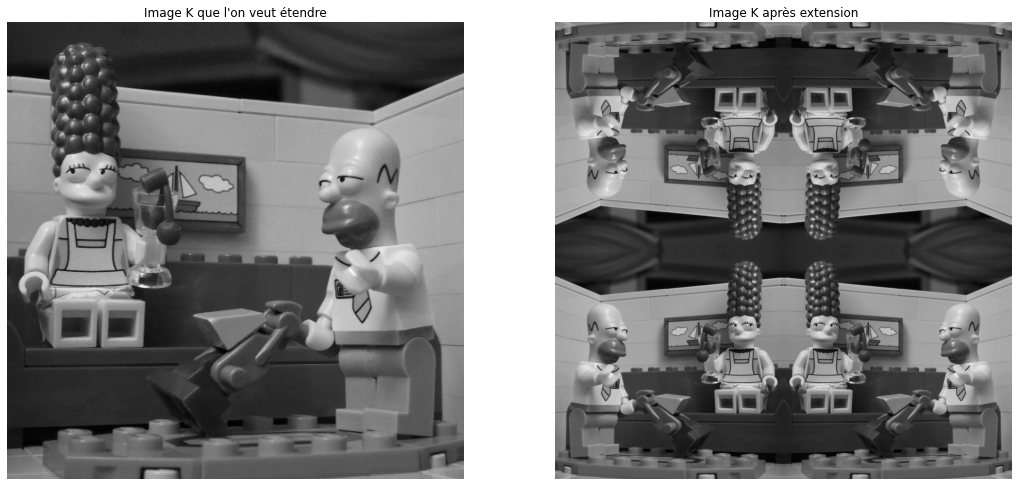

In [3]:
# <!> Cette cellule n'est là que pour visualiser la transformation que l'on fait subir à K, le code n'est pas important.
# Le code utilisé ici est expliqué en détails dans la partie 2.


K = plt.imread('simpson512g.png')
def extension(u):    
    uHaut = u[::-1]
    v = np.block([[uHaut],[u]])
    vgauche = v[:,::-1]
    w = np.block([vgauche,v])
    return w

New_K = extension(K)

fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


ax1.imshow(K,cmap='gray')
ax1.set_title("Image K que l'on veut étendre")
ax1.axis('off')
ax2.imshow(New_K,cmap='gray')
ax2.set_title("Image K après extension")
ax2.axis('off')
plt.show()

De cette façon, $\widetilde{K}$ est 4 fois plus grande que $K$, est périodique et symétrique.  
Ainsi, c'est cette modification que nous voulons faire subir à $V$ pour obtenir $\widetilde{V}$, ou plutôt à l'image dont elle serait le gradient. Il faut alors réaliser que les transformation sur les gradients sont légèrement différentes :
- $\widetilde{V^{x}}$ est bien symétrique par rapport à l'horizontale, mais est antisymétrique par rapport à la vertical $\widetilde{V^{x}}(-x,y)=-\widetilde{V^{x}}(x,y)$
- $\widetilde{V^{y}}$ est bien symétrique par rapport à la verticale, mais est antisymétrique par rapport à l'horizontale $\widetilde{V^{y}}(x,-y)=-\widetilde{V^{y}}(x,y)$  

Il suffit alors d'utiliser la formule $(\star_{5})$ pour trouver une solution $\widetilde{J}$, et enfin de restreindre $\widetilde{J}$ au domaine $\mathcal{R}$ d'origine. De cette façon, la contrainte $(4)$ est elle aussi vérifiée par $\widetilde{J}$ à cause des symétries introduites.

On gardera bien à l'esprit que l'image qui nous intéresse se trouve en bas à droite parmi les 4 copies.

## 2 - Le code

### a) Outillage pour l'algorithme

Voici tout d'abord une fonction **exception_3D** qui sert à s'assurer dans une fonction que l'on utilise bien une image en un seul canal (nuance de gris, canal de rouge, canal de vert, canal de bleu, etc, mais pas 3 couleurs à la fois).

In [2]:
def exception_3D(u):
    if len(u.shape)>2:
        raise Exception("Cette fonction prend en argument des images en niveaux de gris")

On charge les 3 images qui nous servent pour ce projet. L'image $K$ est une image en nuances de gris : elle nous permet de visualiser plus facilement la plupart des fonctions grâce celles-ci travaillent bien souvent sur un seul canal à la fois.  

Comme indiqué dans la partie 1, la zone d'incrustation $\Omega$ au sein de $I$ est spécifiée par les coordonnées de son coin en haut à gauche.

In [3]:
I = plt.imread('ocean.png')
u = plt.imread('requin.png')
K = plt.imread('simpson512g.png')

Omega=[850,400]
v = u[::2,::2]
v.shape

(62, 79, 4)

Les deux fonctions qui suivent sont là pour permettre l'affichage des différentes images du projet. La première concerne les images en nuances de gris, et la deuxième les images en couleurs RGB.

In [5]:
def afficheImageGray(u, title="", size=(8,8)):
    exception_3D(u)
    plt.figure(figsize = size)
    plt.imshow(u, cmap='gray')
    plt.title(title)
    
def afficheImageColor(u, title="", size=(8,8)):
    plt.figure(figsize = size)
    plt.imshow(u)
    plt.title(title)

### b) Calculs du gradient

Voici les deux façons de définir le gradient dont nous avons parlé dans la partie 1. 
- la fonction **gradDiff** utilise la méthode des différences finies, que nous avons vues en cours.
- la fonction **gradFourier** utilise la méthode développée dans la partie 1, à l'aide de la formule $(\star_{3})$.

In [6]:
def gradDiff(u): #méthode des différences finies pour le calcul du gradient
    exception_3D(u)
    H,W = u.shape
  
    gx = u[:,1:W]-u[:,0:W-1]
    gx = np.block([gx,np.zeros((H,1))])
    
    gy = u[1:H,:]-u[0:H-1,:]
    gy = np.block([[gy],[np.zeros((1,W))]])
    
    return gx,gy #renvoie les deux composantes du gradient


def gradFourier(u): #méthode par la TFD pour le calcul du gradient
    exception_3D(u)
    H,W = u.shape
    
    fu = fftshift(fft2(u)) #il faut bien shifter la TFD pour effectuer nos calculs.

    listeX = np.arange(W)
    listeY = np.arange(H)
    coordX , coordY = np.meshgrid(listeX,listeY) #pour obtenir les a et les b dans le calcul de la formule
    fgx = 2*np.pi*1j/W * coordX * fu #on applique la formule (*3)
    fgy = 2*np.pi*1j/H * coordY * fu
    gx = np.real(ifft2(ifftshift(fgx))) #on déshift puis on fait la TFD inverse
    gy = np.real(ifft2(ifftshift(fgy)))
    
    return gx,gy #renvoie les deux composantes du gradient

Voici à titre de comparaison le résultat obtenu sur l'image $K$ via les deux méthodes de calculs du gradient.

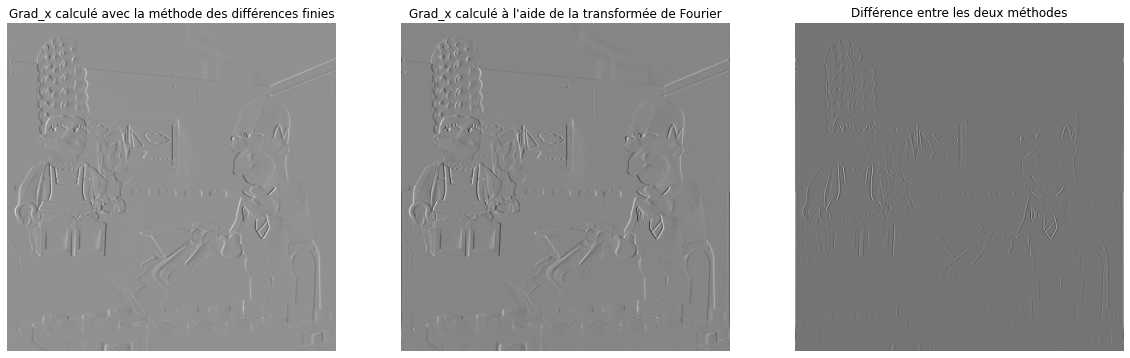

In [7]:
# Exemples :

gx_Diff, gy_Diff = gradDiff(K)
gx_Fourier, gy_Fourier = gradFourier(K)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.imshow(gx_Diff, cmap='gray')
ax1.set_title("Grad_x calculé avec la méthode des différences finies")
ax1.axis('off')
ax2.imshow(gx_Fourier, cmap='gray')
ax2.set_title("Grad_x calculé à l'aide de la transformée de Fourier")
ax2.axis('off')
ax3.imshow(gx_Diff-gx_Fourier, cmap='gray')
ax3.set_title("Différence entre les deux méthodes")
ax3.axis('off')

plt.show()

### c) Extension des gradients

Comme nous l'avons dit dans la partie 1, il nous faut étendre les gradients.  
Les deux composantes du gradient sont étendue de façon à ce que :
- l'extension $\widetilde{V^{x}}$ de $V^{x}$ soit symétrique par rapport à l'axe horizontal mais antisymétrique par rapport à l'axe vertical
- l'extension $\widetilde{V^{y}}$ de $V^{y}$ soit symétrique par rapport à l'axe vertical mais antisymétrique par rapport à l'axe horizontal

In [8]:
def extensionVx(u): #fonction qui prend une image u et l'étend à la manière de Vx
    exception_3D(u) 

    ugauche = -u[:,::-1] #pour apporter l'antisymétrie selon l'axe verticale
    v = np.block([ugauche,u]) #on colle le bloc de gauche au bloc de droite

    vHaut = v[::-1] #pour apporter la symétrie selon l'axe horizontale
    w = np.block([[vHaut],[v]]) #on colle le bloc du haut au bloc du bas
    return w

In [9]:
def extensionVy(u):  #fonction qui prend une image u et l'étend à la manière de Vy
    exception_3D(u)

    uHaut = -u[::-1] #pour apporter l'antisymétrie selon l'axe horizontal
    v = np.block([[uHaut],[u]]) #on colle le bloc du haut au bloc du bas

    vgauche = v[:,::-1]  #pour apporter la symétrie selon l'axe verticale
    w = np.block([vgauche,v]) #on colle le bloc de gauche au bloc de droite
    return w

Voici par exemple une matrice $M$ de nombres, à laquelle nous allons faire subir extensionVx et extensionVy.  
On remarque que $M$ est bien restée inchangée dans les deux cas, en se trouvant toujours en bas à droite de l'extension.  
Les deux extensions $M_{x}$ et $M_{y}$ obtenues sont bien 4 fois plus grandes.  

Attention encore une fois de ne pas confondre les extensions que l'on fait subir par ces deux fonctions, qui concernent le gradient d'une image : les gradients obtenus par extensions ne sont pas périodiques ! Ce sont les images correspondantes aux gradients que l'on veut périodiques et symétriques !

In [10]:
M = np.array([[1,2,3],[4,5,6]])
M_x = extensionVx(M)
M_y = extensionVy(M)
M,M_x,M_y

(array([[1, 2, 3],
        [4, 5, 6]]),
 array([[-6, -5, -4,  4,  5,  6],
        [-3, -2, -1,  1,  2,  3],
        [-3, -2, -1,  1,  2,  3],
        [-6, -5, -4,  4,  5,  6]]),
 array([[-6, -5, -4, -4, -5, -6],
        [-3, -2, -1, -1, -2, -3],
        [ 3,  2,  1,  1,  2,  3],
        [ 6,  5,  4,  4,  5,  6]]))

### d) L'algorithme de Poisson Image Editing par méthode de Fourier

Voici donc le coeur de l'algorithme : la fonction **poissonFourier**.  
Elle prend en entrée les 5 choses suivantes :
- les deux composantes $v_{x}$ et $v_{y}$ du gradient $v$ de l'image à incruster $u$
- l'image $I$ dans laquelle on veut incruster $u$
- les coordonnées $\Omega_{x}$ et $\Omega_{y}$ du coin supérieur gauche de la zone $\Omega$ où incruster $u$ dans $I$
- un mode de calculer de gradient : 0 correspond aux calcul par différence finie, et le 1 (par défaut) correspond au calcul par Fourier


Voici les différentes étapes de l'algorithme :  
- à partir de $I$, on calcul son gradient $\nabla I$ que l'on écrit $(gI_{x},gI_{y})$.
- on construit $V=(V^{x},V^{y})$ en incrustant $v=(v_{x},v_{x})$ au sein de $\nabla I$, par simple copié-collé.
- on étend $V=(V^{x},V^{y})$ à $\widetilde{V}=\big(\widetilde{V^{x}},\widetilde{V^{y}}\big)$, ici noté $(W^{x},W^{y})$
- on calcule la TFD de $W^{x}$ et de $W^{y}$.
- on calcule $\widehat{\widetilde{J}}$ grâce à la formule $(\star_{5})$.
- on fait la TFD inverse de $\widehat{\widetilde{J}}$ pour obtenir $\widetilde{J}$, l'extension de $J$
- on resteint  $\widetilde{J}$ à $\mathcal{R}$ (le cadran en bas à droite) pour obtenir $J$, l'image désirée

In [11]:
def poissonFourier(vx, vy, I, Omega0x, Omega0y, mode=1): 

    # on récupère le gradient de I
    if mode == 0: #le mode permet de choisir la méthode de calcul du gradient
        gIx, gIy = gradDiff(I) #par différences finies
    else :
        gIx, gIy = gradFourier(I) #par Fourier
    
    #on incruste v le gradient de u dans le gradient de I pour former V
    h,w=vx.shape
    Vx = np.copy(gIx)
    Vy = np.copy(gIy)
    Vx[Omega0y:Omega0y+h,Omega0x:Omega0x+w] = vx  #dans la zone Omega, on place v
    Vy[Omega0y:Omega0y+h,Omega0x:Omega0x+w] = vy
    Wx = extensionVx(Vx) #on étend Vx et Vy à Wx et Wy de la façon décrite dans la partie c)
    Wy = extensionVy(Vy)
    
    fWx = fftshift(fft2(Wx)) #on récupère les TFD des extensions
    fWy = fftshift(fft2(Wy)) #on oublie pas de shift la TFD pour faire nos calculs
    
    H,W = Wx.shape 
    listeX = np.arange(1, W + 1)
    listeY = np.arange(1, H + 1)
    coordX , coordY = np.meshgrid(listeX, listeY) #on récupère les fameuses coordonnées a et b dans la formule (*5)
    coordX = coordX - (W//2 + 1) # (De toute façon W et H sont toujours des nombres pairs car des multiples de 4)
    coordY = coordY - (H//2 + 1)
    
    num_a = (2*np.pi*1j/W)*fWx*coordX   #on sépare le calcul en 4 morceaux pour mieux voir les étapes
    num_b = (2*np.pi*1j/H)*fWy*coordY
    num = num_a + num_b #calcul du numérateur
    
    denom_a = ((2*np.pi*1j/W)*coordX)**2
    denom_b = ((2*np.pi*1j/H)*coordY)**2
    denom = denom_a + denom_b #calcul du dénominateur

    np.seterr(invalid='ignore') # Désactiver pour un moment les warnings liés aux divisions par zéro
    fJ = np.zeros((H, W), dtype="complex_") #fJ est la transformée de Fourier du J étendu
    fJ = num/denom # Division par zéro lorsque coordX=0 et coordY=0. On aura alors fJ[h, w]=NaN
    np.seterr(invalid='warn') # Réactiver les warnings
    fJ[H//2, W//2] = 0 # Corriger la valeur NaN, avec le degré de liberté, ici on a choisit 0
    
    SJ = np.real(ifft2(ifftshift(fJ))) #SJ est simplement le J étendu
    return SJ[H//2:, W//2:] #on récupère J en resteignant à R

In [21]:
def poissonFourier2(vx, vy, I, Omega0x, Omega0y, mode=1): 

    # on récupère le gradient de I
    if mode == 0: #le mode permet de choisir la méthode de calcul du gradient
        gIx, gIy = gradDiff(I) #par différences finies
    else :
        gIx, gIy = gradFourier(I) #par Fourier
    
    #on incruste v le gradient de u dans le gradient de I pour former V
    h,w=vx.shape
    Vx = np.copy(gIx)
    Vy = np.copy(gIy)
    Vx[Omega0y:Omega0y+h,Omega0x:Omega0x+w] = vx  #dans la zone Omega, on place v
    Vy[Omega0y:Omega0y+h,Omega0x:Omega0x+w] = vy
    Wx = extensionVx(Vx) #on étend Vx et Vy à Wx et Wy de la façon décrite dans la partie c)
    Wy = extensionVy(Vy)
    
    fWx = fftshift(fft2(Wx)) #on récupère les TFD des extensions
    fWy = fftshift(fft2(Wy)) #on oublie pas de shift la TFD pour faire nos calculs
    
    H,W = Wx.shape 
    listeX = np.arange(1, W + 1)
    listeY = np.arange(1, H + 1)
    coordX , coordY = np.meshgrid(listeX, listeY) #on récupère les fameuses coordonnées a et b dans la formule (*5)
    coordX = coordX - (W//2 + 1) # (De toute façon W et H sont toujours des nombres pairs car des multiples de 4)
    coordY = coordY - (H//2 + 1)
    
    num_a = (2*np.pi*1j/W)*fWx*coordX   #on sépare le calcul en 4 morceaux pour mieux voir les étapes
    num_b = (2*np.pi*1j/H)*fWy*coordY
    num = num_a + num_b #calcul du numérateur
    
    denom_a = ((2*np.pi*1j/W)*coordX)**2
    denom_b = ((2*np.pi*1j/H)*coordY)**2
    denom = denom_a + denom_b #calcul du dénominateur

    np.seterr(invalid='ignore') # Désactiver pour un moment les warnings liés aux divisions par zéro
    fJ = np.zeros((H, W), dtype="complex_") #fJ est la transformée de Fourier du J étendu
    fJ = num/denom # Division par zéro lorsque coordX=0 et coordY=0. On aura alors fJ[h, w]=NaN
    np.seterr(invalid='warn') # Réactiver les warnings
    fJ[H//2, W//2] = 0 # Corriger la valeur NaN, avec le degré de liberté, ici on a choisit 0
    
    SJ = np.real(ifft2(ifftshift(fJ))) #SJ est simplement le J étendu
    return SJ #on récupère J en resteignant à R

### e) Résultats et correction des couleurs

On peut à présent tester l'algorithme.  
On peut aussi bien le tester avec une image en nuances de gris (comme $K$), avec la fonction **lancementGris**, ou bien avec une image couleur RGB, avec la fonction **lancementCouleur**.  
Les deux fonctions prennent en entrée l'image $I$ dans laquelle on incruste, l'image $u$ à incruster, le coin en haut à gauche de $\Omega$, et le mode de calcul des gradients(par défaut 1), qui vaut 1 si on veut le calculer par Fourier, ou 0 par les différences finies. Les fonctions renvoient alors l'image J désirée.

In [36]:
def lancementGris2(I, u, Omega, mode=1):
    exception_3D(I) #on vérifie bien que l'on travaille avec un seul canal
    exception_3D(u)
    
    if mode == 0: #on choisit le mode de calcul du gradient
        vx,vy = gradDiff(u)
    else :
        vx,vy = gradFourier(u)
    
    J = poissonFourier2(vx, vy, I, Omega[0], Omega[1], mode) 
    return J

def lancementGris(I, u, Omega, mode=1):
    exception_3D(I) #on vérifie bien que l'on travaille avec un seul canal
    exception_3D(u)
    
    if mode == 0: #on choisit le mode de calcul du gradient
        vx,vy = gradDiff(u)
    else :
        vx,vy = gradFourier(u)
    
    J = poissonFourier(vx, vy, I, Omega[0], Omega[1], mode) 
    return J
    

def lancementCouleur(I, u, Omega, mode=1):
    
    uR = u[:,:,0] #on sépare les différents canals de u, on travaille séparément avec chacun
    uG = u[:,:,1]
    uB = u[:,:,2]
    
    IR = I[:,:,0] #on sépare les différents canals de I, on travaille séparément avec chacun
    IG = I[:,:,1]
    IB = I[:,:,2]
    
    if mode == 0: #on choisit le mode de calcul du gradient
        vRx,vRy = gradDiff(uR)
        vGx,vGy = gradDiff(uG)
        vBx,vBy = gradDiff(uB)
    else:
        vRx,vRy = gradFourier(uR)
        vGx,vGy = gradFourier(uG)
        vBx,vBy = gradFourier(uB)
     
    JR = poissonFourier(vRx,vRy,IR,Omega[0],Omega[1],mode) #on applique l'algorithme à chaque canal
    JG = poissonFourier(vGx,vGy,IG,Omega[0],Omega[1],mode)
    JB = poissonFourier(vBx,vBy,IB,Omega[0],Omega[1],mode)
    
    J=np.copy(I) #on reconstitue J à partir de ses trois canaux RGB
    J[:,:,0]=JR
    J[:,:,1]=JG
    J[:,:,2]=JB
    return J

def lancementCouleur2(I, u, Omega, mode=1):
    
    uR = u[:,:,0] #on sépare les différents canals de u, on travaille séparément avec chacun
    uG = u[:,:,1]
    uB = u[:,:,2]
    
    IR = I[:,:,0] #on sépare les différents canals de I, on travaille séparément avec chacun
    IG = I[:,:,1]
    IB = I[:,:,2]
    
    if mode == 0: #on choisit le mode de calcul du gradient
        vRx,vRy = gradDiff(uR)
        vGx,vGy = gradDiff(uG)
        vBx,vBy = gradDiff(uB)
    else:
        vRx,vRy = gradFourier(uR)
        vGx,vGy = gradFourier(uG)
        vBx,vBy = gradFourier(uB)
        
    JR = poissonFourier2(vRx,vRy,IR,Omega[0],Omega[1],mode) #on applique l'algorithme à chaque canal
    JG = poissonFourier2(vGx,vGy,IG,Omega[0],Omega[1],mode)
    JB = poissonFourier2(vBx,vBy,IB,Omega[0],Omega[1],mode)
    
    h,w=JR.shape[0],JR.shape[1]
    J=np.zeros((h,w,3))
    
    J[:,:,0]=JR
    J[:,:,1]=JG
    J[:,:,2]=JB
    return J

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1919.5, 1280.5, -0.5)

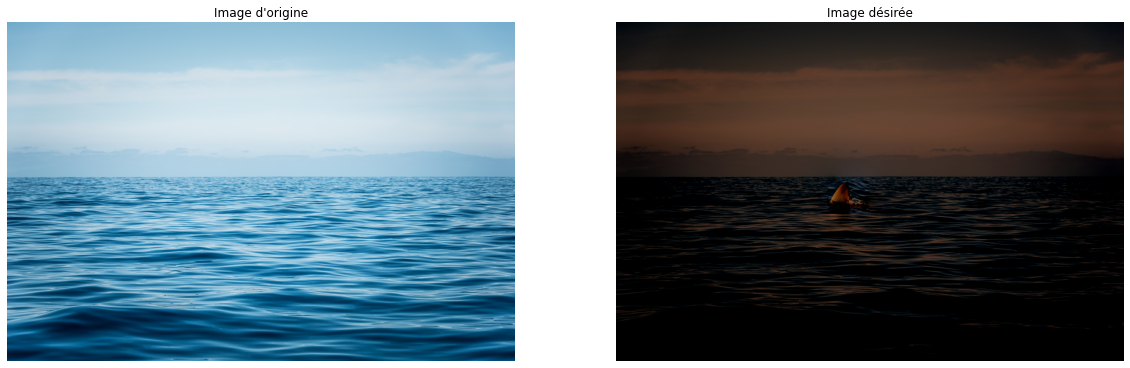

In [38]:
J = lancementCouleur(I, u, [800,600],0) #le mode de calcul du gradient est celui par défaut : par Fourier

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(I)
ax1.set_title("Image d'origine")
ax1.axis('off')
ax2.imshow(J)
ax2.set_title("Image désirée")
ax2.axis('off')

On remarque cependant que l'algorithme a "décallé" les couleurs. Une légère correction des couleurs est alors nécessaire, ici en se basant sur la moyenne des couleurs de l'image d'origine $I$.

In [15]:
def BalancerGris(u_res, u_origin): #pour appliquer la balance sur une image en nuances de gris
    avg_origin = np.mean(u_origin) #on récupère la moyenne de l'image d'origine
    avg_res = np.mean(u_res) #on récupère la moyenne de l'image obtenue
    MatriceCorrection = np.zeros(u_res.shape) + avg_origin - avg_res #on corrige les couleurs en prenant la moyenne d'origine
    return u_res + MatriceCorrection

        
def BalancerCouleur(u_res, u_origin): #pour appliquer la balance sur une image en 3 couleurs RGB
    MatriceCorrection = np.zeros(u_res.shape)
    for color in range(3): #on traite chaque canal séparément
        avgColor_origin = np.mean(u_origin[:,:,color]) #on récupère la moyenne de l'image d'origine
        avgColor_res = np.mean(u_res[:,:,color]) #on récupère la moyenne de l'image obtenue
        MatriceCorrection[:,:,color] = avgColor_origin - avgColor_res #on corrige les couleurs en prenant la moyenne d'origine
    return u_res + MatriceCorrection

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1919.5, 1280.5, -0.5)

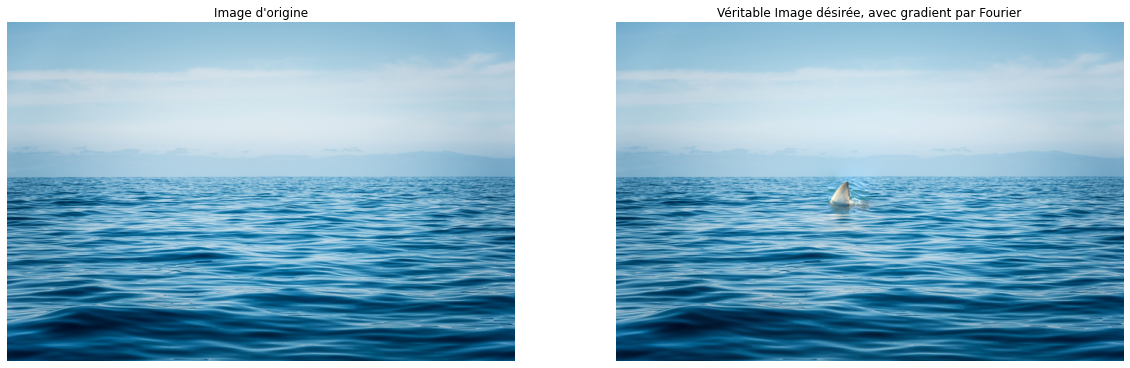

In [39]:
bJ = BalancerCouleur(J, I) #on applique donc à J la correction des couleurs
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(I)
ax1.set_title("Image d'origine")
ax1.axis('off')
ax2.imshow(bJ)
ax2.set_title("Véritable Image désirée, avec gradient par Fourier")
ax2.axis('off')

Voici ce que l'on aurait obtenu si l'on avait utilisé le mode 0 de calcul de gradient, c'est-à-dire par différences finies.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1919.5, 1280.5, -0.5)

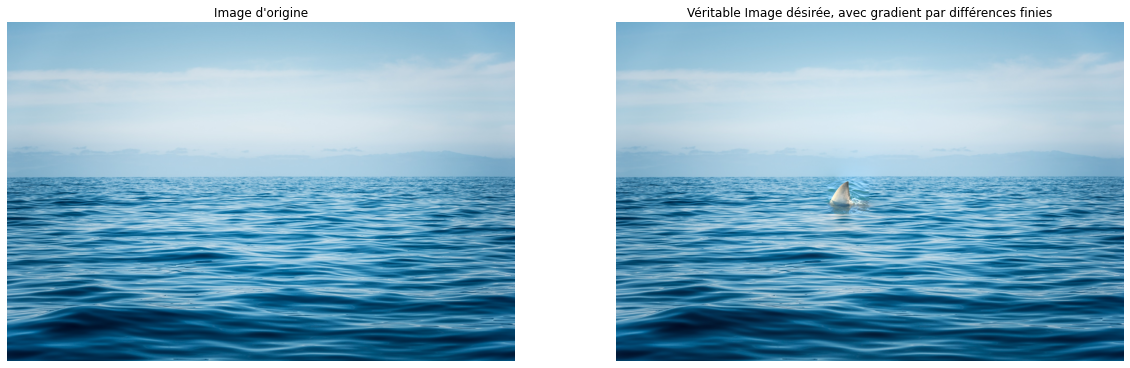

In [17]:
J2 = lancementCouleur(I, u, [800,600],0) #on indique cette fois le mode 0, vu qu'il n'est pas le mode par défaut
bJ2 = BalancerCouleur(J2, I)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(I)
ax1.set_title("Image d'origine")
ax1.axis('off')
ax2.imshow(bJ2)
ax2.set_title("Véritable Image désirée, avec gradient par différences finies")
ax2.axis('off')